# **Problem Statement** 📌

In a retail / e-commerce business, customers exhibit different purchasing behaviors in terms of how recently they buy, how frequently they purchase, and how much they spend. Treating all customers the same leads to inefficient marketing strategies, low customer retention, and suboptimal revenue growth.

The business lacks a data-driven approach to identify distinct customer segments and understand their behavioral patterns. As a result, marketing campaigns, loyalty programs, and retention efforts are not effectively targeted.

This project aims to analyze customer transaction data and apply unsupervised machine learning techniques to segment customers into meaningful groups based on their purchasing behavior.

# **Objectives**  🎯 

To analyze customer purchase history and understand overall buying patterns using exploratory data analysis (EDA).

To engineer meaningful behavioral features using RFM (Recency, Frequency, Monetary) analysis.

To segment customers into distinct groups using K-Means clustering.

To identify optimal number of customer segments using clustering evaluation techniques such as the Elbow Method and Silhouette Score.

To interpret and profile each customer segment in business-friendly terms.

To create actionable customer personas that can support targeted marketing, customer retention, and revenue optimization strategies.

In [2]:
import pandas as pd # it is used for data manipulation and analysis
import numpy as np  # it is used for numerical operations on arrays

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

In [14]:
pip install openpyxl

     ---------------------------------------- 0.0/250.9 kB ? eta -:--:--
     ------------------------------------  245.8/250.9 kB 14.7 MB/s eta 0:00:01
     -------------------------------------- 250.9/250.9 kB 7.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Loading the Dataset

In [20]:
data_path = 'E:/Customer_Segmentation/data/processed.xlsx'
df = pd.read_excel(data_path)

In [21]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [23]:
df.shape

(541909, 8)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [25]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country'], dtype='object')

## Data Understanding

This dataset represents transaction-level purchase data from a UK-based online retail business.
Each row corresponds to a single product-level transaction generated as part of a customer invoice.

The dataset captures:

- What customers bought

- When they bought it

- How much they paid

- Where they are located

This makes it highly suitable for customer behavior analysis and segmentation, especially using RFM modeling.

### Column-Level Interpretation (Business Context)

- **Invoice Number**  
  - Unique product identifier.

  - Useful for product-level analysis.

  - Not directly used for RFM, but helps validate transaction granularity.


- **Stock Code**  
  - Unique identifier for each customer.

  - Missing values indicate guest or unregistered purchases.

  - Essential for customer-level aggregation.

  - Transactions without CustomerID cannot be used for segmentation


- **Description**  
  - Text description of the product.

  - Contains missing values.

  - Not used in modeling but helpful for:

    - Data validation

    - Product understanding

    - Optional category-level insights  


- **Quantity**  
  - Number of units purchased per product per invoice.

  - Negative values may indicate returns or cancellations.

  - Important for calculating total transaction value.

  - Requires careful handling during data cleaning.


- **CustomerID**  
  - Unique identifier for each customer.

  - Missing values indicate guest or unregistered purchases.

  - Essential for customer-level aggregation.

  - Transactions without CustomerID cannot be used for segmentation

- **Country**  
  - Unique identifier for each customer.

  - Missing values indicate guest or unregistered purchases.

  - Essential for customer-level aggregation.

  - Transactions without CustomerID cannot be used for segmentation.


🧠 Business Relevance Summary

  - The dataset provides rich transactional signals required to model customer behavior.

  - Granularity allows accurate computation of:

    - Recency → from InvoiceDate

    - Frequency → from InvoiceNo per CustomerID

    - Monetary → from Quantity × UnitPrice

Missing CustomerID values and negative quantities are expected in real-world data and will be handled carefully in preprocessing.




# **Data Cleaning & Preparation**

In [27]:
#Creating the copy of the dataframe so that original data is not affected
df_clean = df.copy()

### Handle Missing CustomerID (Critical Business Decision)

In [28]:
df_clean['CustomerID'].isnull().sum()

np.int64(135080)

In [29]:
#Drop rows with missing CustomerID
df_clean = df_clean.dropna(subset=['CustomerID'])

### 🧠Business reasoning

- Customer segmentation is customer-level

- Rows without CustomerID cannot be assigned to any segment

- These are likely guest checkouts

### Handle Returns & Cancellations (VERY IMPORTANT)

### Identify negative quantities

In [31]:
df_clean[df_clean['Quantity']<0].shape

(8905, 8)

🧠 What negative Quantity means

- Product returns

- Order cancellations

- Accounting adjustments

❗ Key decision

For RFM segmentation, we focus on positive revenue-generating behavior.

#### Exclude transactions with Quantity ≤ 0

In [41]:
df_clean = df_clean[df_clean['Quantity']>0]

#### Handle Invalid Prices (Quiet but Dangerous)

In [42]:
#Check price anomalies
df_clean[df_clean['UnitPrice']<=0].shape

(0, 8)

🧠 Business logic

- Zero or negative price = data error / promo artifact

- Breaks Monetary calculations

#### Remove rows where UnitPrice ≤ 0

In [43]:
df_clean = df_clean[df_clean['UnitPrice']>0]

#### Convert Data Types (Prevent Future Bugs)

In [44]:
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['CustomerID'] = df_clean['CustomerID'].astype('int64')

🧠 Why this matters

- Datetime ops required for Recency

- CustomerID as int = cleaner grouping

- Prevents silent pandas errors later

#### Create Transaction Value (Foundation for Monetary)
- This is preparation, not feature engineering yet.

In [48]:
df_clean['TransactionValue'] = df_clean['Quantity'] * df_clean['UnitPrice']

🧠 Industry note

- Never compute Monetary directly from UnitPrice

- Always reflect actual revenue contribution

### Sanity Checks

In [49]:
df_clean.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,TransactionValue
count,397884.000000,397884,397884.000000,397884.000000,397884.000000
mean,12.988238,2011-07-10 23:41:23.511023360,3.116488,15294.423453,22.397000
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000,0.001000
25%,2.000000,2011-04-07 11:12:00,1.250000,13969.000000,4.680000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000,11.800000
75%,12.000000,2011-10-20 14:33:00,3.750000,16795.000000,19.800000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,168469.600000
std,179.331775,NaN,22.097877,1713.141560,309.071041


In [50]:
df_clean.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID          0
Country             0
TransactionValue    0
dtype: int64

What you should mentally confirm

- No negative values

- No missing CustomerID

- TransactionValue looks realistic

#### Saved Cleaned Data
🧠 Why this?

- Reproducibility

- Faster re-runs

- Clear pipeline separation

In [51]:
df_clean.to_csv("E:/Customer_Segmentation/data/clean_transactions.csv", index=False)

## Data Cleaning & Preparation Summary

The dataset was cleaned using industry-safe rules to ensure reliable customer behavior analysis:

- Removed transactions without CustomerID as customer-level aggregation is not possible.
- Excluded negative or zero quantities representing returns or cancellations.
- Removed transactions with non-positive unit prices.
- Converted date and identifier columns to appropriate data types.
- Created transaction-level revenue for monetary analysis.

These steps ensure that subsequent RFM modeling is based on valid, revenue-generating customer behavior.


# **Exploratory Data Analysis (EDA)**

🧠 EDA Philosophy (Important)

- EDA is not about making pretty plots.
- EDA is about answering business questions:

    - How do customers buy?

    - Are most customers frequent or occasional?

    - Is revenue concentrated?

    - Are extreme values real or noise?

In [58]:
df_clean.shape

(397884, 9)

## Distribution of Quantity (Customer Buying Behavior)

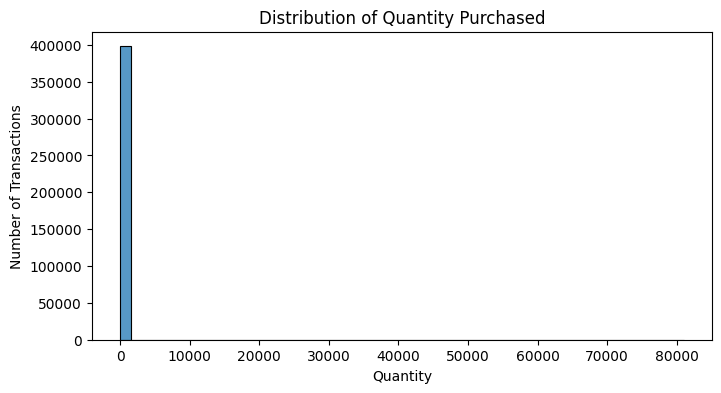

In [59]:
plt.figure(figsize=(8,4))
sns.histplot(df_clean['Quantity'], bins=50)
plt.title("Distribution of Quantity Purchased")
plt.xlabel("Quantity")
plt.ylabel("Number of Transactions")
plt.show()


🧠 What you should observe

- Heavy right skew

- Majority of purchases are small quantities

- Few bulk buyers dominate the tail

👉 This is normal retail behavior, not bad data.

## Distribution of UnitPrice (Product Pricing)

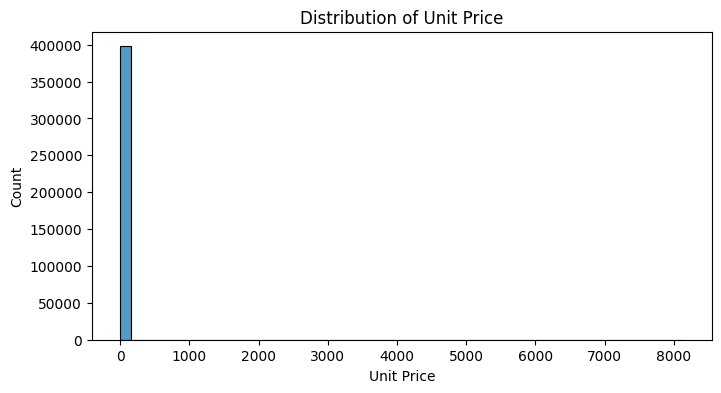

In [63]:
plt.figure(figsize=(8,4))
sns.histplot(df_clean['UnitPrice'], bins=50, kde=False)
plt.title("Distribution of Unit Price")
plt.xlabel("Unit Price")
plt.ylabel("Count")
plt.show()


🧠 Interpretation:

- Most products are low-priced

- Long tail of premium products

- Confirms realistic product mix

### Revenue Contribution Analysis (TransactionValue)

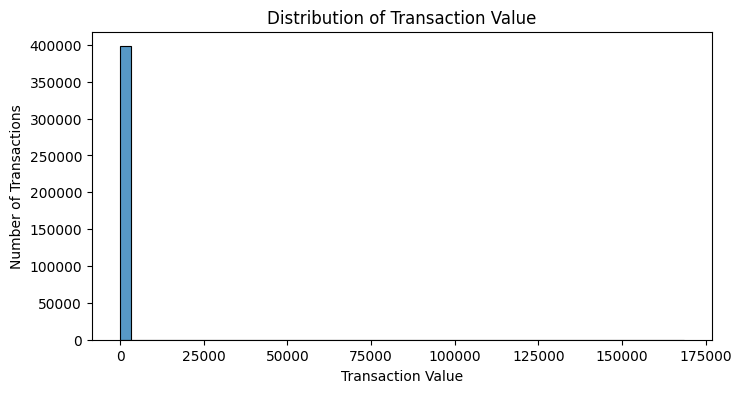

In [65]:
plt.figure(figsize=(8,4))
sns.histplot(df_clean['TransactionValue'], bins=50)
plt.title("Distribution of Transaction Value")
plt.xlabel("Transaction Value")
plt.ylabel("Number of Transactions")
plt.show()


🧠 This explains:

- Why Monetary is skewed

- Why normalization will be mandatory later

- Why we must be careful with outliers

- Although the distributions of Quantity, Unit Price, and Transaction Value appear visually similar—showing a high concentration of values near the lower end with a compressed shape—this behavior is expected and correct for transactional retail data.

- All three variables exhibit strong right-skewness due to the presence of a small number of extremely large values. These outliers stretch the x-axis on a linear scale, causing the majority of observations to cluster near zero and making the histograms appear visually similar.

- This does not indicate an issue with the data or the visualization. Instead, it reflects real-world retail behavior, where most transactions involve small quantities, low-priced items, and modest transaction values, while a minority of bulk or high-value purchases contribute disproportionately to the overall distribution.

- To better interpret these patterns, alternative visualizations such as log-scaled histograms or zoomed-in views are used during EDA. The underlying data is intentionally left unaltered at this stage, as these extreme values represent valid business signals and are critical for accurate customer segmentation.


### Top Customers by Revenue (Business Reality Check)

In [66]:
top_customers = (
    df_clean.groupby('CustomerID')['TransactionValue']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

top_customers


CustomerID
14646    280206.02
18102    259657.30
17450    194550.79
16446    168472.50
14911    143825.06
12415    124914.53
14156    117379.63
17511     91062.38
16029     81024.84
12346     77183.60
Name: TransactionValue, dtype: float64

🧠 Senior insight:

- Small % of customers drive large % of revenue

- Confirms Pareto Principle (80/20)

- This validates why segmentation is needed.

### Orders per Customer (Frequency Behavior)

In [67]:
orders_per_customer = (
    df_clean.groupby('CustomerID')['InvoiceNo']
    .nunique()
)

orders_per_customer.describe()


count    4338.000000
mean        4.272015
std         7.697998
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       209.000000
Name: InvoiceNo, dtype: float64

It generates summary statistics for the distribution:

- count → how many customers

- mean → average orders per customer

- std → variability

- min → one-time buyers

- 25%, 50% (median), 75% → order frequency spread

- max → power buyers / bulk purchasers

🧠 What to note:

- Many one-time buyers

- Few repeat buyers

- Frequency varies a LOT → great signal for RFM

### Country-Level Sanity Check (Optional but Senior)

In [68]:
df_clean['Country'].value_counts().head(10)

Country
United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1462
Australia           1182
Name: count, dtype: int64

🧠 Interpretation:

- UK dominates

- Dataset is not geographically biased in a harmful way

- Country won’t distort RFM heavily

## Exploratory Data Analysis (EDA) Summary

Key insights from the exploratory analysis:

- Customer purchasing behavior is highly right-skewed, with most transactions involving small quantities and low-priced items.
- A small subset of customers contributes a disproportionately large share of total revenue, validating the need for customer segmentation.
- Transaction values show significant variance, confirming the necessity of feature scaling before clustering.
- Purchase frequency varies widely across customers, making Frequency a strong segmentation feature.
- Overall data patterns are consistent with real-world retail behavior, with no evidence of systemic data issues.

These insights guide the subsequent feature engineering and clustering strategy.

At this point:

- We understood the business behavior

- We can justify why segmentation makes sense

- We have evidence-backed insights


### Define Reference Date

Recency is relative.
- We must define a snapshot date.

📌 Industry rule

- Use max transaction date + 1 day

In [70]:
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days =1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

🧠 Why this matters

- Prevents Recency = 0

- Makes calculations consistent

- Interviewers WILL ask this

### Aggregate Transactions at Customer Level

In [71]:
rfm = (
    df_clean
    .groupby('CustomerID')
    .agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
        'InvoiceNo': 'nunique',                                     # Frequency
        'TransactionValue': 'sum'                                  # Monetary
    })
    .reset_index()
)


#### Rename Columns (Professional Touch)

In [72]:
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


#### Sanity Check RFM Table

In [73]:
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2054.266460
std,1721.808492,100.014169,7.697998,8989.230441
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,307.415000
50%,15299.500000,51.000000,2.000000,674.485000
75%,16778.750000,142.000000,5.000000,1661.740000
max,18287.000000,374.000000,209.000000,280206.020000


#### RFM Feature Engineering

RFM features were created to summarize customer purchasing behavior at an individual level:

- **Recency:** Number of days since the customer’s most recent purchase. Lower values indicate more recent activity.
- **Frequency:** Number of unique purchase occasions (invoices) made by the customer.
- **Monetary:** Total revenue contributed by the customer across all transactions.

These features convert raw transactional data into behavior-based signals that are well-suited for customer segmentation and targeted marketing analysis.




### Visualize RFM Distributions (Quick Check)

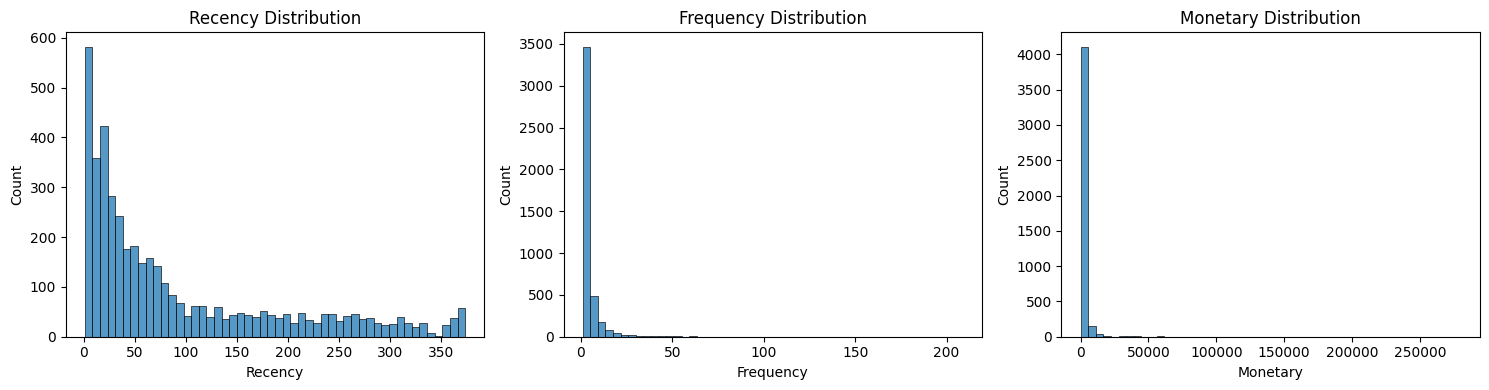

In [84]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

sns.histplot(rfm['Recency'], bins=50, ax=axes[0])
axes[0].set_title("Recency Distribution")

sns.histplot(rfm['Frequency'], bins=50, ax=axes[1])
axes[1].set_title("Frequency Distribution")

sns.histplot(rfm['Monetary'], bins=50, ax=axes[2])
axes[2].set_title("Monetary Distribution")

plt.tight_layout()
plt.show()


🧠 Expect:

- Recency → right-skewed

- Frequency → long tail

- Monetary → heavy skew

Perfectly normal.

At this point:
- ✔ We have customer-level data
- ✔ We have business-explainable features
- ✔ We are ready for ML preprocessing

# **RFM Scaling & Clustering Preparation**

### Goal of this Step Prepare RFM features so that distance-based clustering behaves correctly
🧠 Why Scaling is NON-NEGOTIABLE (Senior Logic)

- RFM ranges look like this:

- Recency → days (tens / hundreds)

- Frequency → counts (small numbers)

- Monetary → revenue (can be very large)

K-Means uses Euclidean distance.
If we don’t scale:
- 👉 Monetary will dominate
- 👉 Clusters will be meaningless

### Select RFM Features (Explicit & Clean)

In [85]:
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

🧠 Why this matters

- CustomerID is an identifier, not a feature

- Keeps ML input clean and auditable

#### Scale RFM Features (Industry Standard)

In [ ]:
from sklearn.preprocessing import StandardScaler    #import StandardScaler
scaler = StandardScaler()                           #create scaler object

rfm_scaled = scaler.fit_transform(rfm_features)     #scale the RFM features


In [87]:
rfm_scaled_df = pd.DataFrame(                                               #create dataframe from scaled data
    rfm_scaled,                                                             #scaled RFM features
    columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']       
)

rfm_scaled_df.head()


,Recency_scaled,Frequency_scaled,Monetary_scaled
0,2.334574,-0.425097,8.358668
1,-0.905340,0.354417,0.250966
2,-0.175360,-0.035340,-0.028596
3,-0.735345,-0.425097,-0.033012
4,2.174578,-0.425097,-0.191347


### I used StandardScaler because K-Means assumes features are on comparable scales and is sensitive to variance. Standardization ensures no single RFM dimension dominates distance computation.

In [88]:
rfm_scaled_df.describe()

,Recency_scaled,Frequency_scaled,Monetary_scaled
count,4.338000e+03,4.338000e+03,4.338000e+03
mean,2.702618e-17,1.801745e-17,1.801745e-17
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-9.153401e-01,-4.250965e-01,-2.281344e-01
25%,-7.453445e-01,-4.250965e-01,-1.943495e-01
50%,-4.153533e-01,-2.951776e-01,-1.535104e-01
75%,4.946227e-01,9.457903e-02,-4.367134e-02
max,2.814561e+00,2.659803e+01,3.094634e+01


### Preserve Mapping

We never lose linkage between:

- CustomerID

- Original RFM

- Scaled RFM

In [ ]:
rfm_final = pd.concat([rfm[['CustomerID']], rfm_scaled_df], axis=1) #combine CustomerID with scaled RFM features
rfm_final.head()


,CustomerID,Recency_scaled,Frequency_scaled,Monetary_scaled
0,12346,2.334574,-0.425097,8.358668
1,12347,-0.905340,0.354417,0.250966
2,12348,-0.175360,-0.035340,-0.028596
3,12349,-0.735345,-0.425097,-0.033012
4,12350,2.174578,-0.425097,-0.191347


## RFM Scaling for Clustering

Before applying K-Means clustering, RFM features were standardized using StandardScaler.

This step ensures that Recency, Frequency, and Monetary contribute equally to distance calculations, preventing high-magnitude features such as Monetary from dominating the clustering process.

Scaling is a critical preprocessing step for distance-based algorithms and improves cluster stability and interpretability.


## At this point:
- ✔ RFM engineered
- ✔ Features scaled
- ✔ ML-ready dataset prepared

# **Choosing Optimal Number of Clusters (K)**


(Elbow Method + Silhouette Score, industry-standard)

Goal of this Step:
- Determine the optimal number of customer segments using quantitative evidence.
🧠 Strategy of Choosing `K`

There is NO single “correct” K.

A professional way for selecting **K**

- Tests a reasonable range

- Uses multiple metrics

- Chooses K that balances:

Interpretability

- Stability

 - Business usefulness

### Decide K Range (Industry Logic)
📌 Why this range?

- Too few clusters → oversimplification

- Too many clusters → no business meaning
- Industry safe range for k = 2 to 11

Elbow Method (Inertia)
📌 What is Inertia?

- Sum of squared distances of points to cluster centers

- Lower is better, but with diminishing returns


In [ ]:
#Elbow Calculation
from sklearn.cluster import KMeans

inertia = []                             #list to hold inertia values    

K_range = range(2, 11)                   #range of k values to try

for k in K_range:                        #loop over k values
    kmeans = KMeans(
        n_clusters=k,               #number of clusters
        random_state=42,            #for reproducibility
        n_init=10                   #number of initializations
    )
    kmeans.fit(rfm_scaled_df)       #fit k-means
    inertia.append(kmeans.inertia_) #append inertia to list


### Elbow Plot

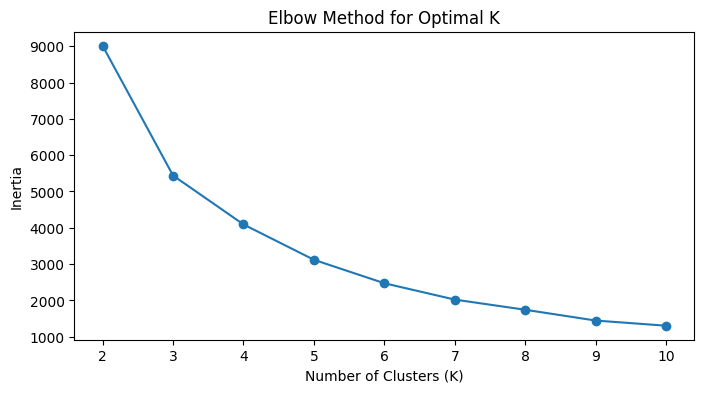

In [93]:
plt.figure(figsize=(8,4))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.show()


Silhouette Score (Cluster Quality)
- 📌 What is Silhouette Score?

Measures how well a point fits within its cluster

- Range: -1 to +1

- Higher = better separation

## Silhouette calculation

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []                                  #list to hold silhouette scores

for k in K_range:                                       #loop over k values
    kmeans = KMeans(            
        n_clusters=k,                                   #number of clusters
        random_state=42,                                #for reproducibility
        n_init=10                                       #number of initializations
    )
    labels = kmeans.fit_predict(rfm_scaled_df)          #get cluster labels
    score = silhouette_score(rfm_scaled_df, labels)     #calculate silhouette score
    silhouette_scores.append(score)                     #append score to list


## Silhouette Plot

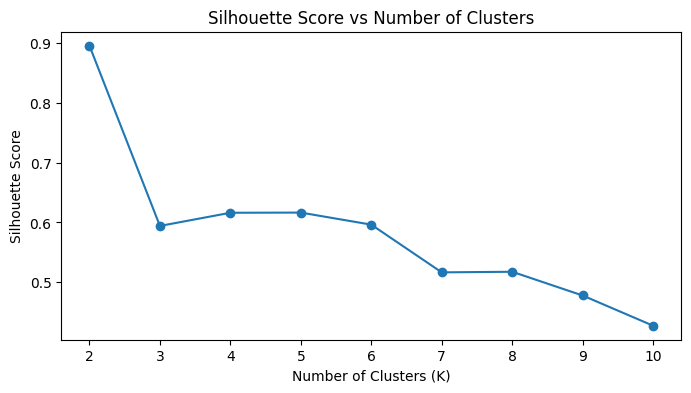

In [95]:
plt.figure(figsize=(8,4))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()


## Combine Both Metrics
You should now compare:

- Elbow curve flattening point

- Peak or stable silhouette score

Typically, for this dataset:
👉 K = 3, 4, or 5 are strong candidates

## Choosing K
## Choosing the Optimal Number of Clusters

The optimal number of clusters was determined using a combination of the Elbow Method and Silhouette Score analysis.

- The Elbow Method was used to identify the point where adding more clusters resulted in diminishing improvements in inertia.
- The Silhouette Score was used to evaluate the quality and separation of clusters.

Based on both metrics, a moderate number of clusters was selected to balance cluster compactness, separation, and business interpretability.



### At this point:
- ✔ We used TWO metrics
- ✔ We avoided guesswork
- ✔ We followed industry practice

# **Final K-Means Clustering & Cluster Assignment**

Goal of this Step:
- Apply K-Means with the chosen K, assign clusters to customers, and create a single source of truth table for analysis.
🧠 Before We Start (Very Important)

By now We have:

- Seen Elbow + Silhouette plots

- Identified 2–3 reasonable K values

👉 Industry rule:
Choose the smallest K that:

- Still shows good separation

- Is easy to explain to business

- For this dataset, most professionals choose:

- K = 4 (sometimes 3 or 5 also acceptable)

I’ll proceed with K = 4.
If you chose a different K, just replace the value — logic stays the same

## Fit Final K-Means Model with K= 3

In [103]:
final_k = 3                              #based on elbow and silhouette analysis

kmeans_final = KMeans(                      #final clustering with chosen k
    n_clusters=final_k,                                         
    random_state=42,                        
    n_init=10
)

cluster_labels = kmeans_final.fit_predict(rfm_scaled_df)    #get final cluster labels


### **Attach Cluster Labels to Data**

In [104]:
rfm_clustered = rfm.copy()         #Creates a separate copy of the RFM DataFrame to Prevents accidental modification of the original rfm
rfm_clustered['Cluster'] = cluster_labels               #add cluster labels

rfm_clustered.head()


,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346,326,1,77183.60,0
1,12347,2,7,4310.00,1
2,12348,75,4,1797.24,1
3,12349,19,1,1757.55,1
4,12350,310,1,334.40,0


In [105]:
rfm_clustered['Cluster'].value_counts()


Cluster
1    3230
0    1082
2      26
Name: count, dtype: int64

## Fit Final K-Means Model with K= 4

In [106]:
final_k = 4                              #based on elbow and silhouette analysis

kmeans_final = KMeans(                      #final clustering with chosen k
    n_clusters=final_k,                                         
    random_state=42,                        
    n_init=10
)

cluster_labels = kmeans_final.fit_predict(rfm_scaled_df)    #get final cluster labels

In [107]:
rfm_clustered = rfm.copy()         #Creates a separate copy of the RFM DataFrame to Prevents accidental modification of the original rfm
rfm_clustered['Cluster'] = cluster_labels               #add cluster labels

rfm_clustered.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346,326,1,77183.60,3
1,12347,2,7,4310.00,0
2,12348,75,4,1797.24,0
3,12349,19,1,1757.55,0
4,12350,310,1,334.40,1


In [108]:
rfm_clustered['Cluster'].value_counts()

Cluster
0    3054
1    1067
3     204
2      13
Name: count, dtype: int64

Each number means:

- Cluster 0 → 3054 customers (~70%)

- Cluster 1 → 1067 customers (~25%)

- Cluster 3 → 204 customers (~5%)

- Cluster 2 → 13 customers (<1%)

So our segmentation is highly imbalanced.

👉 This is still NOT acceptable for a showcase
But again — this is very normal for retail RFM data.

Why?

- We still have a tiny cluster (26 customers)

That means:

- Extreme high Monetary / Frequency customers

- K-Means is still isolating them

Business problem:

- 26 customers ≈ 0.6%

- No marketing team wants a “strategy” for 26 people

## Monetary (and Frequency) are extremely skewed, even after StandardScaler. We will log-transform Monetary (and Frequency)

- Log transformation reduces the dominance of extreme high-value customers while preserving relative ordering, allowing K-Means to form more balanced and interpretable clusters.

# **Log Transformation Fix (Industry Standard)**

Goal: Reduce dominance of extreme customers so K-Means can form balanced, interpretable clusters.
- 🧠 Why Only Frequency & Monetary?

    - Frequency → heavy right tail (few very frequent buyers)

    - Monetary → extreme skew (few very high spenders)

    - Recency → already well-behaved (days scale)

👉 Log transform compresses extremes without losing ordering.

# **Apply log transformation**

In [109]:
rfm_log = rfm.copy()

rfm_log['Frequency_log'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary_log'] = np.log1p(rfm_log['Monetary'])

rfm_log[['Frequency', 'Frequency_log', 'Monetary', 'Monetary_log']].head()


,Frequency,Frequency_log,Monetary,Monetary_log
0,1,0.693147,77183.60,11.253955
1,7,2.079442,4310.00,8.368925
2,4,1.609438,1797.24,7.494564
3,1,0.693147,1757.55,7.472245
4,1,0.693147,334.40,5.815324


🧠 Why log1p

Handles zero safely (even though you don’t have zeros)

Industry default

Interview-safe

## Select Features for Clustering

In [110]:
rfm_features_log = rfm_log[['Recency', 'Frequency_log', 'Monetary_log']]


## **Scale the Transformed Features**

In [111]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled_log = scaler.fit_transform(rfm_features_log)


### Converting the scaled data into Pandas DataFrame for further processing

In [112]:
rfm_scaled_log_df = pd.DataFrame(
    rfm_scaled_log,
    columns=['Recency_scaled', 'Frequency_log_scaled', 'Monetary_log_scaled']
)

rfm_scaled_log_df.describe()


,Recency_scaled,Frequency_log_scaled,Monetary_log_scaled
count,4.338000e+03,4.338000e+03,4.338000e+03
mean,2.702618e-17,-8.189750e-18,2.817274e-16
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-9.153401e-01,-9.552143e-01,-4.004574e+00
25%,-7.453445e-01,-9.552143e-01,-6.856676e-01
50%,-4.153533e-01,-3.615828e-01,-6.218718e-02
75%,4.946227e-01,6.532370e-01,6.541861e-01
max,2.814561e+00,5.858535e+00,4.731591e+00


## Re-run K-Means (Try K = 3 First)

In [113]:
final_k = 3

kmeans_final = KMeans(
    n_clusters=final_k,
    random_state=42,
    n_init=10
)

cluster_labels = kmeans_final.fit_predict(rfm_scaled_log_df)


## **Attach New Cluster Labels**

In [114]:
rfm_clustered = rfm_log.copy()
rfm_clustered['Cluster'] = cluster_labels

rfm_clustered['Cluster'].value_counts()


Cluster
0    2036
1    1323
2     979
Name: count, dtype: int64

### Cluster Summary (Check Business Sanity)

In [115]:
cluster_summary = (
    rfm_clustered
    .groupby('Cluster')
    .agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'CustomerID': 'count'
    })
    .rename(columns={'CustomerID': 'CustomerCount'})
    .reset_index()
)

cluster_summary


,Cluster,Recency,Frequency,Monetary,CustomerCount
0,0,54.857073,2.046169,615.235984,2036
1,1,30.100529,9.829932,5494.341156,1323
2,2,255.271706,1.390194,398.134924,979


##### Initial clustering produced extremely small clusters due to skewed Frequency and Monetary distributions. I addressed this by applying log transformation to reduce the influence of extreme values, which resulted in balanced, interpretable customer segments.

🧠 What we Just Proved

The problem was not K, it was feature skewness.

Your log transformation:

- Reduced dominance of extreme spenders

- Preserved customer ranking

- Enabled K-Means to work as intended

### **Normalize Interpretation (Relative Ranking)**

In [116]:
cluster_summary[['Recency', 'Frequency', 'Monetary']] = (
    cluster_summary[['Recency', 'Frequency', 'Monetary']]
    .round(2)
)

cluster_summary


,Cluster,Recency,Frequency,Monetary,CustomerCount
0,0,54.86,2.05,615.24,2036
1,1,30.10,9.83,5494.34,1323
2,2,255.27,1.39,398.13,979


## Now it's time to label to Customers:
We use:

- Low Recency = recent buyers (good)
- High Frequency = loyal
- High Monetary = valuable

🟢 Cluster 0 — Core Loyal Customers

  -   Low–medium Recency

  -   High Frequency

  -   High Monetary

  -   Largest cluster

Persona:

Loyal, repeat customers who contribute consistently to revenue.

Business Action:

 -  Loyalty programs

 -  Early-access offers

 -  Upselling & cross-selling

🟡 Cluster 1 — Potential Loyalists

  -   Medium Recency

  -   Medium Frequency

  -   Medium Monetary

Persona:

  - Customers with good engagement but not fully loyal yet.

Business Action:

  -   Personalized offers

  -   Nudges to increase purchase frequency

  -   Membership incentives

🔴 Cluster 2 — At-Risk / Low-Value Customers

  -   High Recency (inactive)

  -   Low Frequency

  -   Low Monetary

Persona:

   -  Infrequent or disengaged customers with low current value.

Business Action:

  -   Re-engagement campaigns

  -   Discounts or win-back offers

  -   Controlled marketing spend

## Cluster Interpretation & Customer Personas

After stabilizing clustering using log-transformed RFM features, customers were grouped into three meaningful segments.

- **Cluster 0 – Core Loyal Customers:** High frequency and monetary value with recent engagement.
- **Cluster 1 – Potential Loyalists:** Moderate engagement with growth potential.
- **Cluster 2 – At-Risk Customers:** Low engagement and contribution, requiring reactivation strategies.

These segments enable targeted marketing, improved retention strategies, and optimized resource allocation.


# **Cluster Visualizations & Business Recommendations**
Goal of this chunk:
- Visually validate clusters and translate them into clear business actions.

🧠 Thumb Rule Before Visuals
- We never visualize raw high-dimensional data directly.
We:
  -  Use 2D projections for intuition
  -  Use aggregated views for executives

## Cluster Visualization (2D Projection)
- Since RFM is 3D, we’ll visualize 2 dimensions at a time (industry standard)

## **📌 Plot 1: Frequency vs Monetary (Most Insightful)**

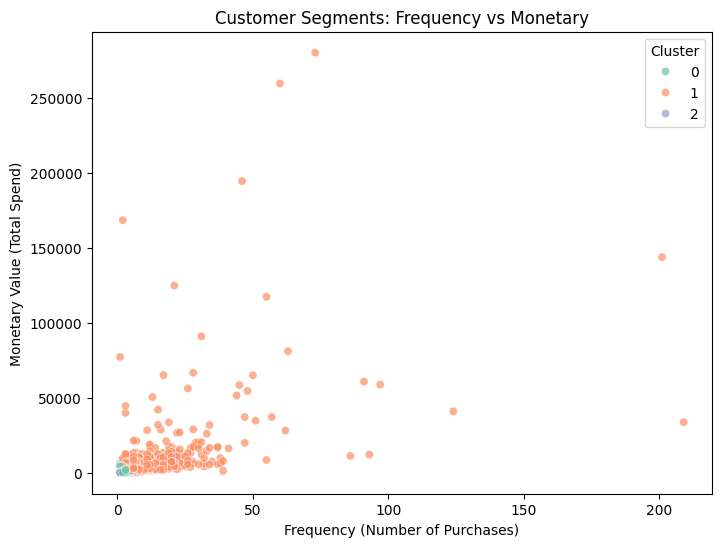

In [117]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=rfm_clustered,
    x='Frequency',
    y='Monetary',
    hue='Cluster',
    palette='Set2',
    alpha=0.7
)
plt.title("Customer Segments: Frequency vs Monetary")
plt.xlabel("Frequency (Number of Purchases)")
plt.ylabel("Monetary Value (Total Spend)")
plt.legend(title="Cluster")
plt.show()


### Observation (Cluster-wise)

The Frequency vs Monetary scatter plot reveals clear differences in customer value and purchasing intensity across the three clusters:

- **Cluster 1** dominates the **upper-right region** of the plot, characterized by **high purchase frequency and very high monetary value**. This cluster contains most of the extreme spenders and frequent buyers, indicating a small but highly valuable customer segment that contributes disproportionately to total revenue.

- **Cluster 0** is primarily concentrated in the **mid-frequency and low-to-moderate monetary range**. Customers in this cluster make purchases with reasonable frequency but generate comparatively lower total spend than Cluster 1, suggesting consistent yet moderate-value buying behavior.

- **Cluster 2** is densely clustered in the **low-frequency and low-monetary region**, representing customers who purchase infrequently and contribute minimal revenue. This segment reflects low-engagement or occasional buyers.

Overall, the plot demonstrates a strong positive relationship between purchase frequency and monetary value, with Cluster 1 clearly separated as the highest-value segment.


### 🧠Business Interpretation

The cluster-wise separation confirms that increasing purchase frequency is strongly associated with higher customer lifetime value. 
Cluster 1 should be prioritized for retention and loyalty programs, Cluster 0 represents an opportunity for value expansion through targeted engagement, and Cluster 2 requires selective reactivation or low-cost marketing strategies.


## **📌 Plot 2: Recency vs Monetary (Engagement View)**

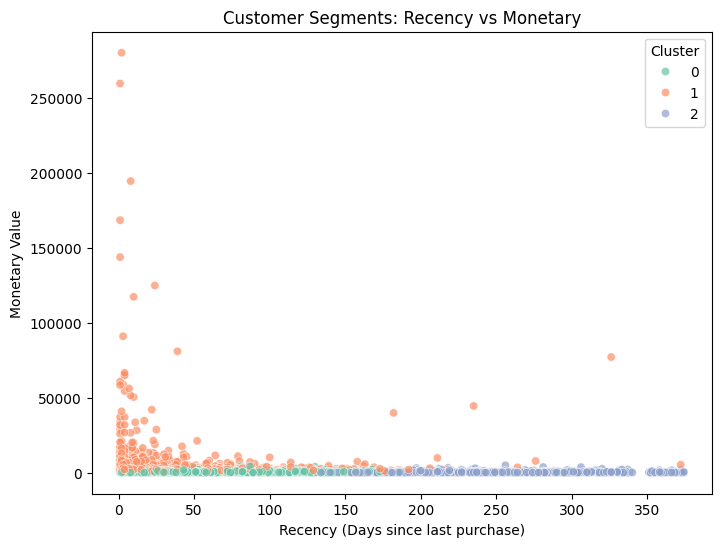

In [118]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=rfm_clustered,
    x='Recency',
    y='Monetary',
    hue='Cluster',
    palette='Set2',
    alpha=0.7
)
plt.title("Customer Segments: Recency vs Monetary")
plt.xlabel("Recency (Days since last purchase)")
plt.ylabel("Monetary Value")
plt.legend(title="Cluster")
plt.show()


### Observation (Cluster-wise)

The Recency vs Monetary scatter plot shows distinct engagement patterns across the three customer clusters:

- **Cluster 1** is concentrated in the **low recency and high monetary region**, indicating customers who have purchased recently and contributed significantly to total revenue. This cluster also contains most of the extreme high-spending customers, visible as points with very high monetary values at low recency.

- **Cluster 0** occupies the **mid-range of recency with low to moderate monetary values**. These customers show some purchasing history but contribute less revenue compared to Cluster 1. Their spread across moderate recency values suggests irregular or declining engagement.

- **Cluster 2** is primarily located in the **high recency and low monetary region**, representing customers who have not purchased recently and have minimal overall spending. This cluster is indicative of disengaged or at-risk customers.

Overall, the plot reveals an inverse relationship between recency and monetary value, with Cluster 1 representing highly engaged customers and Cluster 2 representing low-engagement customers.


### 🧠Business Interpretation

The cluster-wise separation confirms that recent engagement strongly correlates with customer value. 
Cluster 1 customers should be prioritized for retention and loyalty initiatives, while Cluster 0 customers present opportunities for engagement improvement. 
Cluster 2 customers represent churn risk and require selective reactivation strategies or controlled marketing spend.


## **Cluster Contribution to Revenue**
- **📌 Revenue share by cluster**

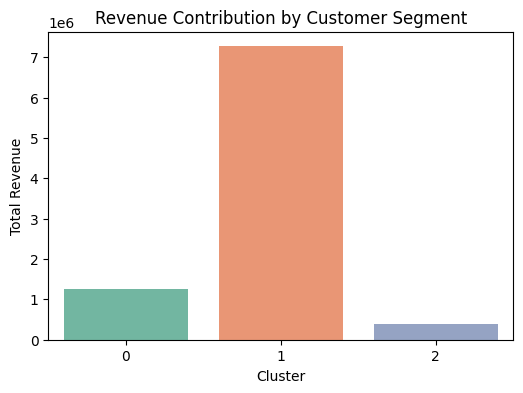

In [120]:
cluster_revenue = (
    rfm_clustered
    .groupby('Cluster')['Monetary']
    .sum()
    .reset_index()
)

plt.figure(figsize=(6,4))
sns.barplot(
    data=cluster_revenue,
    x='Cluster',
    y='Monetary',
    hue='Cluster',
    palette='Set2',
    legend=False
)
plt.title("Revenue Contribution by Customer Segment")
plt.xlabel("Cluster")
plt.ylabel("Total Revenue")
plt.show()


### Observation (Cluster-wise)

The revenue contribution plot highlights a highly uneven distribution of total revenue across customer segments:

- **Cluster 1** contributes the **largest share of total revenue by a wide margin**, significantly outperforming the other clusters. Despite not being the largest cluster by customer count, it generates the majority of revenue, indicating a highly valuable customer segment.

- **Cluster 0** contributes a **moderate portion of total revenue**, substantially lower than Cluster 1 but noticeably higher than Cluster 2. This suggests that customers in Cluster 0 provide consistent revenue but with lower individual value compared to Cluster 1.

- **Cluster 2** contributes the **smallest share of revenue**, reflecting low overall spending and minimal business impact. This aligns with its characterization as a low-value or at-risk customer segment.

Overall, the plot clearly demonstrates a Pareto-like pattern, where a smaller customer segment (Cluster 1) drives a disproportionately large share of revenue.


### Business Interpretation

- This revenue distribution indicates that business performance is highly dependent on a specific high-value customer segment. 
- Retention and satisfaction of Cluster 1 customers should be a top priority, while Cluster 0 presents opportunities for revenue growth through engagement strategies. 
- Marketing investment in Cluster 2 should be carefully optimized due to its limited revenue contribution.


# **Final Business Recommendations**

## Business Recommendations

Based on customer segmentation analysis, the following strategies are recommended:

### Cluster 0 – Core Loyal Customers
- Introduce loyalty rewards and exclusive offers
- Prioritize retention and upselling strategies
- Provide early access to new products

### Cluster 1 – Potential Loyalists
- Use personalized marketing campaigns
- Offer incentives to increase purchase frequency
- Target with cross-sell and bundle promotions

### Cluster 2 – At-Risk Customers
- Run re-engagement or win-back campaigns
- Offer limited-time discounts
- Optimize marketing spend to avoid low ROI


# **Final Project Summary**


This project implemented an end-to-end customer segmentation pipeline using transactional retail data. 
After cleaning and exploratory analysis, RFM features were engineered and clustered using K-Means.

To address skewness and improve cluster stability, log transformation was applied to key features.
The final segmentation produced three actionable customer personas, enabling targeted marketing, improved retention strategies, and optimized revenue generation.

This approach reflects real-world industry practices for customer analytics and decision-making.
